0. 모듈 불러오기

In [ ]:
# 파일을 다운받기 위해서는 gdown을 설치
!pip install gdown

In [ ]:
import os
import zipfile
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

1. 파일 다운받기

In [ ]:
#https://drive.google.com/file/d/1XNhZNtJNUDJVMN-un2fWS5UaPfHNaJAZ/view?usp=sharing
!gdown --id 1XNhZNtJNUDJVMN-un2fWS5UaPfHNaJAZ --output /tmp/mask_data.zip

Downloading...
From: https://drive.google.com/uc?id=1XNhZNtJNUDJVMN-un2fWS5UaPfHNaJAZ
To: /tmp/mask_data.zip
100% 64.2M/64.2M [00:00<00:00, 80.3MB/s]


In [ ]:
local_zip = '/tmp/mask_data.zip' #파일 자체의 경로
zip_ref = zipfile.ZipFile(local_zip, 'r') #읽기모드
zip_ref.extractall('/tmp/')
zip_ref.close()

"\nlocal_zip = '/tmp/data_test.zip' \nzip_ref = zipfile.ZipFile(local_zip, 'r') \n# ZipFile의 첫 번째 매개변수는 파일 자체의 경로입니다. 두 번째 매개변수는 읽기 모드로 파일을 엽니다.\nzip_ref.extractall('/tmp/')\nzip_ref.close()\n"

2. 데이터 전처리

In [ ]:
validation_ratio = 1/8  # validation_split 파라미터로 train set과 validation set을 나눌 수 있습니다.

TRAINING_DIR = "/tmp/mask_data/data_train" 
datagen = ImageDataGenerator(validation_split=validation_ratio,
                             rescale = 1./255)
# 본 영상은 0-255의 RGB 계수로 구성되는데, 이 같은 입력값은 모델을 효과적으로 학습시키기에 너무 높습니다 (통상적인 learning rate를 사용할 경우). 
# 그래서 이를 1/255로 스케일링하여 0-1 범위로 변환시켜줍니다. 이는 다른 전처리 과정에 앞서 가장 먼저 적용됩니다.  / 출처: https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256),  # 모든 이미지의 크기가 256x256로 조정됩니다.
    class_mode='categorical', # 다중 클래스 문제는 class_mode는 ‘categorical’로 지정합니다.
    batch_size=24, # 몇 개의 샘플로 가중치를 갱신할 것인지 지정합니다.
)

validation_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256), 
    class_mode='categorical',
    batch_size=24, 
)

TEST_DIR = "/tmp/mask_data/data_test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=8
)

Found 7553 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


3. 모델구축

In [ ]:
model = tf.keras.models.Sequential([ 
    # 64개의 필터 적용,  kernel_size = (3,3) 는 필터의 크기를 의미합니다.
    # input_shape(가로, 세로, 흑백(=1)or컬러(=3))
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flattn은 3차원 배열(가로,세로,컬러)인 이미지를 1차원 배열로 바꿔줍니다.
    tf.keras.layers.Flatten(),
    # Dropout()는 특정 노드에 학습이 지나치게 몰리는 것을 방지하기 위해 랜덤하게 일부 노드를 꺼줍니다.
    # Dropout을 통해 과적합을 조금 더 효과적으로 회피할 수 있습니다. /  출처: https://snowdeer.github.io/machine-learning/2018/01/10/convolution-neural-network/
    tf.keras.layers.Dropout(0.5),
    # 출력뉴런 수 512개
    tf.keras.layers.Dense(512, activation='relu'),
    # 출력뉴런 수 2개(라벨 개수)
    tf.keras.layers.Dense(2, activation='softmax')
])


model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=30, steps_per_epoch=15, verbose = 1, validation_data = validation_generator, validation_steps=3)
# epochs : 학습 반복 횟수, (batch_size)*(step_per_epoch)=(Training_data)
# steps_per_epoch : 한 epoch에 사용한 스텝 수를 지정합니다
# validation_steps : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정합니다.
# verbose : verbose : 학습 중 출력되는 문구를 설정합니다.
# 0 : 아무 것도 출력하지 않습니다.
# 1 : 훈련의 진행도를 보여주는 진행 막대를 보여줍니다.
# 2 : 미니 배치마다 손실 정보를 출력합니다.   /   출처: https://wikidocs.net/32105


Epoch 1/30
15/15 [==============================] - 92s 6s/step - loss: 1.5764 - accuracy: 0.4778 - val_loss: 0.6789 - val_accuracy: 0.5972
Epoch 2/30
15/15 [==============================] - 81s 5s/step - loss: 0.6827 - accuracy: 0.6056 - val_loss: 0.6109 - val_accuracy: 0.7917
Epoch 3/30
15/15 [==============================] - 79s 5s/step - loss: 0.6286 - accuracy: 0.7111 - val_loss: 0.6225 - val_accuracy: 0.6667
Epoch 4/30
15/15 [==============================] - 80s 5s/step - loss: 0.5620 - accuracy: 0.7639 - val_loss: 0.6014 - val_accuracy: 0.7500
Epoch 5/30
15/15 [==============================] - 78s 5s/step - loss: 0.4525 - accuracy: 0.8444 - val_loss: 0.8518 - val_accuracy: 0.6389
Epoch 6/30
15/15 [==============================] - 78s 5s/step - loss: 0.4446 - accuracy: 0.8028 - val_loss: 0.3901 - val_accuracy: 0.8611
Epoch 7/30
12/15 [=======================>......] - ETA: 15s - loss: 0.3909 - accuracy: 0.8646

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/15 [==============================] - 84s 6s/step - loss: 0.3676 - accuracy: 0.8694 - val_loss: 0.2838 - val_accuracy: 0.8889
Epoch 8/30
15/15 [==============================] - 81s 5s/step - loss: 0.3751 - accuracy: 0.8611 - val_loss: 0.4307 - val_accuracy: 0.8194
Epoch 9/30
15/15 [==============================] - 80s 5s/step - loss: 0.4285 - accuracy: 0.8167 - val_loss: 0.3128 - val_accuracy: 0.8611
Epoch 10/30
15/15 [==============================] - 79s 5s/step - loss: 0.4129 - accuracy: 0.8361 - val_loss: 0.3062 - val_accuracy: 0.9028
Epoch 11/30
15/15 [==============================] - 79s 5s/step - loss: 0.3071 - accuracy: 0.8722 - val_loss: 0.3913 - val_accuracy: 0.8056
Epoch 12/30
15/15 [==============================] - 79s 5s/step - loss: 0.3283 - accuracy: 0.8722 - val_loss: 0.1894 - val_accuracy: 0.9306
Epoch 13/30
15/15 [==============================] - 79s 5s/step - loss: 0.2968 - accuracy: 0.9028 - val_loss: 0.4614 - val_accuracy: 0.8333
Epoch 14/30
15/15 [========

4. 모델 시각화

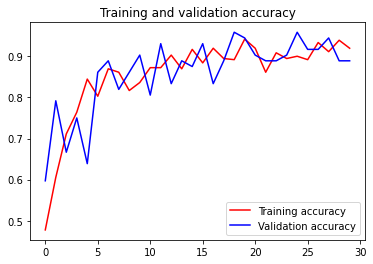

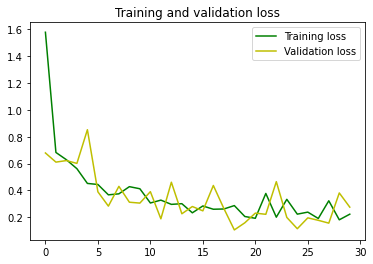

In [ ]:
import matplotlib.pyplot as plt # 결과를 시각화 하기위한 라이브러리
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.legend(loc='best')
plt.title('Training and validation accuracy') 


plt.figure(2)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.legend(loc='best')
plt.title('Training and validation loss') 



plt.show()

5. 모델 성능 평가

In [ ]:
# 훈련된 모델을 test_generator로 평가합니다.
print("-- Evaluate(정확도) --") 
scores = model.evaluate_generator(test_generator, steps=5) 
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate(정확도) --


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


accuracy: 82.50%


6. 이미지 직접 입력

Saving mask.jpg to mask (1).jpg
[[1. 0.]]


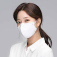

with_mask


In [ ]:
# 훈련된 모델에 이미지를 입력하여 직접 결과를 보실 수 있습니다.

import numpy as np
from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  image_1 = cv2.imread(fn, cv2.IMREAD_REDUCED_COLOR_4)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  if classes[0,0] >= 0.9:
    cv2_imshow(image_1)
    print("with_mask")
  else:
    cv2_imshow(image_1)
    print("without_mask")


Saving 마스크없.jpg to 마스크없.jpg
[[0. 1.]]


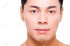

without_mask


In [ ]:
# 훈련된 모델에 이미지를 입력하여 직접 결과를 보실 수 있습니다.

import numpy as np
from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  image_1 = cv2.imread(fn, cv2.IMREAD_REDUCED_COLOR_4)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  if classes[0,0] >= 0.9:
    cv2_imshow(image_1)
    print("with_mask")
  else:
    cv2_imshow(image_1)
    print("without_mask")


In [ ]:
# 훈련된 모델에 이미지를 입력하여 직접 결과를 보실 수 있습니다.

import numpy as np
from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  image_1 = cv2.imread(fn, cv2.IMREAD_REDUCED_COLOR_4)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  if classes[0,0] >= 0.9:
    cv2_imshow(image_1)
    print("with_mask")
  else:
    cv2_imshow(image_1)
    print("without_mask")


Saving mask_without.jpg to mask_without.jpg
[[1.9597243e-19 1.0000000e+00]]


without_mask


In [ ]:
# 훈련된 모델에 이미지를 입력하여 직접 결과를 보실 수 있습니다.

import numpy as np
from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  image_1 = cv2.imread(fn, cv2.IMREAD_REDUCED_COLOR_4)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  if classes[0,0] >= 0.9:
    cv2_imshow(image_1)
    print("with_mask")
  else:
    cv2_imshow(image_1)
    print("without_mask")

Saving mask_with.jpg to mask_with.jpg
[[1. 0.]]


with_mask
